<a href="https://colab.research.google.com/github/RegiTelma/NLP/blob/main/Language_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import random
import shutil
import tensorflow as tf
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tqdm import tqdm

In [ ]:
# Where the text files are going to live.
dataset_path = "dataset"
dataset_path_all = os.path.join(dataset_path, "all")
dataset_path_train = os.path.join(dataset_path, "train")
dataset_path_valid = os.path.join(dataset_path, "valid")

# Just use 20 files.
file_number = 20

# Gather the corpus if it has not been gathered yet.
if not os.path.exists(dataset_path):

    # Create all the folders.
    for path in [dataset_path, dataset_path_all, dataset_path_train, dataset_path_valid]:
        if not os.path.exists(path):
            os.mkdir(path)

    # Clone the repo.
    !git clone https://github.com/vilmibm/lovecraftcorpus

    # Find all the files.
    paths_all = glob.glob("lovecraftcorpus/*.txt")
    print(sorted(paths_all))

    # Do not use all.
    paths_all = paths_all[:file_number]

    # Split 80/20.
    split_index = int(len(paths_all) * 0.8)
    paths_train = paths_all[:split_index]
    paths_valid = paths_all[split_index:]

    # Copy files.
    def copy(paths, destination):
        for path in paths:
            shutil.copy2(path, destination)
    copy(paths_all, dataset_path_all)
    copy(paths_train, dataset_path_train)
    copy(paths_valid, dataset_path_valid)

    # Delete repo.
    !rm -rf lovecraftcorpus

    # Done.
    print("Corpus downloaded.")

In [ ]:
#!rm -rf dataset

In [ ]:
def create_dataset(dataset_path):
  dataset= preprocessing.text_dataset_from_directory(
      dataset_path,
      labels=None,
      batch_size=32, #Not training!
      seed=42
  )
  return dataset

dataset_original_all= create_dataset(dataset_path_all)
dataset_original_train= create_dataset(dataset_path_train)
dataset_original_valid= create_dataset(dataset_path_valid)

Found 20 files belonging to 1 classes.
Found 16 files belonging to 1 classes.
Found 4 files belonging to 1 classes.


In [ ]:
for batch in dataset_original_all:
  #print(batch.shape)
  for sample in batch:
    print(sample)
    #break

tf.Tensor(b'THE DUNWICH HORROR\n\nGorgons and Hydras, and Chimaeras--dire stories of Celaeno and the Harpies--may reproduce themselves in the brain of superstition--but they were there before. They are transcripts, types--the archetypes are in us, and eternal. How else should the recital of that which we know in a waking sense to be false come to affect us all? Is it that we naturally conceive terror from such objects, considered in their capacity of being able to inflict upon us bodily injury? O, least of all! These terrors are of older standing. They date beyond body--or without the body, they would have been the same...That the kind of fear here treated is purely spiritual--that it is strong in proportion as it is objectless on earth, that it predominates in the period of our sinless infancy--are difficulties the solution of which might afford some probable insight into our ante-mundane condition, and a peep at least into the shadowland of pre-existence.\n\n--Charles Lamb: Witches a

In [ ]:
vocabulary_size=10_000

encoder= layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=None, #coz we dont want it to be lower case
    split="whitespace",
    output_mode="int"
)
encoder.adapt(dataset_original_all)

In [ ]:
vocabulary=encoder.get_vocabulary()
print(vocabulary[-100:]) #from 100 by [100:] and last 100 by [-100]

['reachable', 'reach,', 'raving.', 'raving', 'ravines', 'ravenous', 'raven', 'raved', 'ravages', 'rattling,', 'rate,', 'rat-tracks', 'rat-poison', 'rat-like', 'rapped', 'rapidity.', 'range;', 'random', 'rambles.', 'rambles,', 'rambled', 'rains', 'raining', 'rain;', 'railing', 'rail,', 'raiders,', 'rags,', 'rags', 'raged', 'radius', 'radiated', 'radiant', 'racial', 'quote', 'quietly,', 'quiet;', 'quickly.', 'question.', 'queerer', 'quarters;', 'quarter,', 'quarries.', 'python', 'puzzlingly', 'puzzling.', 'putrid', 'pursuits', 'pursuit;', 'pursuit.', 'pursuing', 'pursuer.', 'purr', 'purposes.', 'purposes', 'purposefully', 'purposeful,', 'purposeful', 'purplish', 'purple,', 'purchase', 'puppy', 'pupil', 'pulsing', 'pull,', 'public,', 'psychology.', 'psychologists,', 'psychologists', 'psychologist', 'psychologically', 'psychic', 'pseudo-memory.', 'pseudo-memories.', "pryin'", 'pry', 'prow', 'provoking', 'provided.', 'protruded', 'protracted', 'protecting', 'protected', 'protect', 'prosy', 

#Dataset for autoregression

In [ ]:
import time

sequence_length=32

padding_token_id=0

def create_dataset_for_autoregression(dataset):
  x_inputs=[]
  y_outputs=[]

  for books in dataset:
    books=encoder(books).numpy()

    for book in tqdm(books):

      #Remove padding at the end.
      book= [x for x in list(book) if x != padding_token_id]

      #Add padding at the beginning.
      padding=[padding_token_id] * sequence_length
      book = padding + book

      #Create inputs and outputs.
      for start_index in range(0, len(book) - sequence_length):
        x=book[start_index:start_index + sequence_length]
        assert len(x)==sequence_length
        y= book[start_index + sequence_length]

        x_inputs+=[x]
        y_outputs+=[y]

  return tf.data.Dataset.from_tensor_slices((x_inputs,y_outputs))

dataset_train= create_dataset_for_autoregression(dataset_original_train)
dataset_valid=create_dataset_for_autoregression(dataset_original_valid)
print("Done!")

100%|██████████| 4/4 [00:00<00:00, 16.93it/s]


Done!


In [ ]:
def decode(indices):
  return " ".join([vocabulary[index] for index in indices if  index!=0])


for input,output in dataset_train.take(4):
  print("input:", "," .join([str(x) for x in input.numpy()]))
  print("output:", output.numpy())
  print("input decoded: ", decode(input))
  print("output decoded: ", decode(output))

input: 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
output: 1
input decoded:  


TypeError: ignored

In [ ]:
def render_history(history):
    plt.title("Training loss vs. validation loss")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Training accuracy vs. validation accuracy")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

#Train an LSTM

In [ ]:
embedding_size=128

model=models.Sequential()
model.add(layers.Embedding(vocabulary_size,embedding_size,input_length=sequence_length))
model.add(layers.LSTM(256))
model.add(layers.Dense(vocabulary_size,activation="softmax"))
model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history=model.fit(
    dataset_train.cache().shuffle(200_000).batch(2**6),
    epochs=10,
    validation_data=dataset_valid.cache().batch(2**6)
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 32, 128)           1280000   
                                                                 
 lstm_3 (LSTM)               (None, 256)               394240    
                                                                 
 dense_3 (Dense)             (None, 10000)             2570000   
                                                                 
Total params: 4,244,240
Trainable params: 4,244,240
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
3020/3020 [==============================] - 55s 17ms/step - loss: 6.2109 - accuracy: 0.1443 - val_loss: 6.0525 - val_accuracy: 0.1617
Epoch 2/10
3020/3020 [==============================] - 26s 8ms/step - loss: 5.5678 - accuracy: 0.1831 - val_loss: 5.8757 - val_accuracy: 0.1768
Epoch 3/10
3020/3

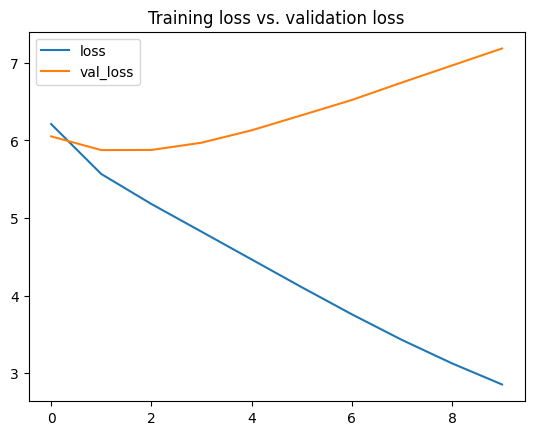

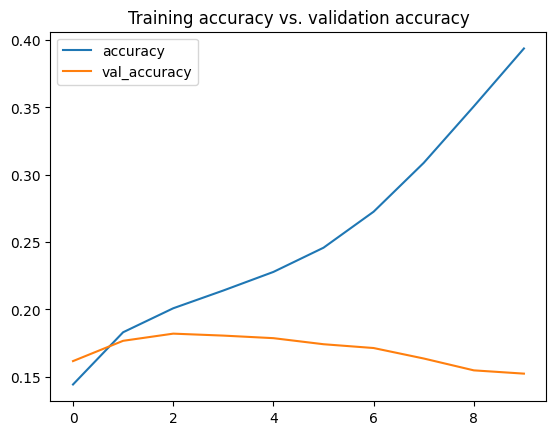

In [ ]:
import matplotlib.pyplot as plt
render_history(history)

In [ ]:
import numpy as np

def generate(model, seed_text, generated_sequence_length, temperature):

    input_sequence = encoder(seed_text).numpy()

    generated_sequence = list(input_sequence[::]) #Indices

    # Pad.
    padding = [0] * (sequence_length - len(input_sequence))
    input_sequence = padding + list(input_sequence)

    # Generate the sequence by repeatedly predicting.
    while len(generated_sequence) < generated_sequence_length:
        prediction = model.predict(np.expand_dims(input_sequence, axis=0), verbose=0)
        predicted_index = get_index_from_prediction(prediction[0], temperature)
        generated_sequence.append(predicted_index)
        input_sequence = input_sequence[1:]
        input_sequence.append(predicted_index)

    # Convert the generated sequence to a string.
    text = decode(generated_sequence)
    print(text)
    print("")


def get_index_from_prediction(prediction, temperature=0.0):
    """ Gets an index from a prediction. """

    # Zero temperature - use the argmax.
    if temperature == 0.0:
        return np.argmax(prediction)

    # Non-zero temperature - do some random magic.
    else:
        prediction = np.asarray(prediction).astype('float64')

        #
        prediction = np.log(prediction) / temperature

        #softmax
        exp_prediction= np.exp(prediction)
        prediction = exp_prediction / np.sum(exp_prediction) #probabilit distribution

        probabilities = np.random.multinomial(1, prediction, 1)
        return np.argmax(probabilities)


generate(model, "we are all doomed", 100, temperature=1.0)

we are all doomed and [UNK] [UNK] with old, [UNK] the will left this [UNK] but we saw me when the Greater in turn on the university. That mouth and Asenath had got a large [UNK] and whose identity was now in the face, my own son, trembled with which the husband [UNK] and use from every age. Many to the sprightly [UNK] And yet the farmer [UNK] [UNK] I visited the [UNK] with [UNK] with what comes from the Providence air. In the seventh of reflected breathless intense intense fact, he stopped up by it. It was far as

